In [ ]:
import os
import cv2
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from keras import backend as K
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, Reshape, Bidirectional, LSTM, Dense, Lambda, Activation, BatchNormalization, Dropout

In [ ]:
! pip install kaggle

In [ ]:
! mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
! cp kaggle.json ~/.kaggle/

cp: cannot stat 'kaggle.json': No such file or directory


In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [ ]:
! kaggle datasets download landlord/handwriting-recognition


Dataset URL: https://www.kaggle.com/datasets/landlord/handwriting-recognition
License(s): CC0-1.0
handwriting-recognition.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
! unzip handwriting-recognition.zip

Streaming output truncated to the last 5000 lines.
  inflating: validation_v2/validation/VALIDATION_5003.jpg  
  inflating: validation_v2/validation/VALIDATION_5004.jpg  
  inflating: validation_v2/validation/VALIDATION_5005.jpg  
  inflating: validation_v2/validation/VALIDATION_5006.jpg  
  inflating: validation_v2/validation/VALIDATION_5007.jpg  
  inflating: validation_v2/validation/VALIDATION_5008.jpg  
  inflating: validation_v2/validation/VALIDATION_5009.jpg  
  inflating: validation_v2/validation/VALIDATION_5010.jpg  
  inflating: validation_v2/validation/VALIDATION_5011.jpg  
  inflating: validation_v2/validation/VALIDATION_5012.jpg  
  inflating: validation_v2/validation/VALIDATION_5013.jpg  
  inflating: validation_v2/validation/VALIDATION_5014.jpg  
  inflating: validation_v2/validation/VALIDATION_5015.jpg  
  inflating: validation_v2/validation/VALIDATION_5016.jpg  
  inflating: validation_v2/validation/VALIDATION_5017.jpg  
  inflating: validation_v2/validation/VALIDATION_

In [ ]:
x = pd.read_csv('written_name_train_v2.csv')
y = pd.read_csv('written_name_validation_v2.csv')
print(len(x))
print(len(y))


330961
41370


In [ ]:

# train = pd.read_csv('written_name_train_v2.csv')
# valid = pd.read_csv('written_name_validation_v2.csv')



# x = pd.read_csv('written_name_train_v2.csv')
# y = pd.read_csv('written_name_validation_v2.csv')

# Calculate the midpoint for splitting
train_midpoint = len(x) // 3
valid_midpoint = len(y) // 1

# Split the DataFrames
train = x.iloc[:train_midpoint]
# train_second_half = train.iloc[train_midpoint:]

valid = y.iloc[:valid_midpoint]
# valid_second_half = valid.iloc[valid_midpoint:]
# print(len(train))
# print(len(valid))

In [ ]:
print(len(train))
print(len(valid))

110320
41370


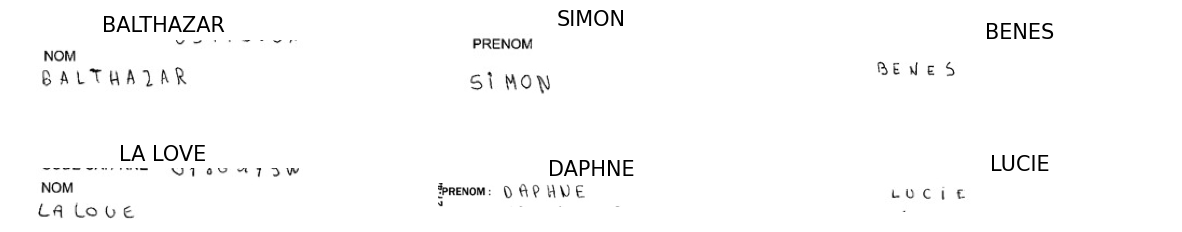

In [ ]:

plt.figure(figsize=(15, 10))


for i in range(6):
    # plt.subplot(n of rows, n of cols, index of the image (this has null images))
    ax = plt.subplot(2, 3, i+1)

    img_dir = 'train_v2/train/'+train.loc[i, 'FILENAME']

    # cv2.imread(path=img_dir, flag=specifies the way in which image should be read)
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    # cv2.imread(X=data of the image, colormap instance)
    plt.imshow(image, cmap = 'gray')
    plt.title(train.loc[i, 'IDENTITY'], fontsize=15)
    # this is for the dl title
    plt.axis('off')

plt.subplots_adjust(wspace=0.4, hspace=-0.8)

In [ ]:
# Cleaning the data by checking for null values

# print(train['IDENTITY'].isnull)
print("Number of NaNs in train set      : ", train['IDENTITY'].isnull().sum())
print("Number of NaNs in validation set : ", valid['IDENTITY'].isnull().sum())

Number of NaNs in train set      :  192
Number of NaNs in validation set :  78


In [ ]:
# Dropping the null values from the training and testing data
train.dropna(axis=0, inplace=True)
valid.dropna(axis=0, inplace=True)

<ipython-input-13-7d64220b68e1>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train.dropna(axis=0, inplace=True)
<ipython-input-13-7d64220b68e1>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid.dropna(axis=0, inplace=True)


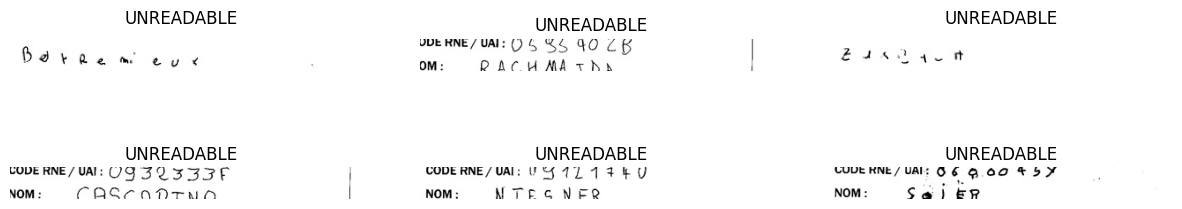

In [ ]:
# Removing the data with the label 'UNREADABLE'
unreadable = train[train['IDENTITY'] == 'UNREADABLE']
# resets the index of the DataFrame, and uses the default one instead
unreadable.reset_index(inplace = True, drop=True)

plt.figure(figsize=(15, 10))

for i in range(6):
    ax = plt.subplot(2, 3, i+1)
    img_dir = 'train_v2/train/'+unreadable.loc[i, 'FILENAME']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    plt.imshow(image, cmap = 'gray')
    plt.title(unreadable.loc[i, 'IDENTITY'], fontsize=12)
    plt.axis('off')

plt.subplots_adjust(wspace=0.2, hspace=-0.8)

In [ ]:
train = train[train['IDENTITY'] != 'UNREADABLE']
valid = valid[valid['IDENTITY'] != 'UNREADABLE']

In [ ]:
# converting some lowercase labels to uppercase to maintain uniformity
train['IDENTITY'] = train['IDENTITY'].str.upper()
valid['IDENTITY'] = valid['IDENTITY'].str.upper()

<ipython-input-16-5acf03739bdf>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['IDENTITY'] = train['IDENTITY'].str.upper()
<ipython-input-16-5acf03739bdf>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['IDENTITY'] = valid['IDENTITY'].str.upper()


In [ ]:
# resetting the index to maintain uniform leveling
train.reset_index(inplace = True, drop=True)
valid.reset_index(inplace = True, drop=True)

In [ ]:
def preprocess(img):
  # h=height and w=widdth to define the shape of the image
    (h, w) = img.shape

    final_img = np.ones([64, 256])*255

    # cutting the image if the bigger

    if w > 256:
        img = img[:, :256]

    if h > 64:
        img = img[:64, :]

    # rotating the image clockwise to bring the image shape to (x,y)
    final_img[:h, :w] = img
    return cv2.rotate(final_img, cv2.ROTATE_90_CLOCKWISE)

In [ ]:

train_size = 25000
valid_size= 2600

In [ ]:
# 3gb
train_x = []

for i in range(train_size):
    img_dir = 'train_v2/train/'+train.loc[i, 'FILENAME']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    image = preprocess(image)
    image = image/255.
    train_x.append(image)

In [ ]:
# 3.6gb
valid_x = []

for i in range(valid_size):
    img_dir = 'validation_v2/validation/'+valid.loc[i, 'FILENAME']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    image = preprocess(image)
    image = image/255.
    valid_x.append(image)

In [ ]:
# .reshape(a: array_like = -1(we want numpy to figure out as the dimensions are unknown)
# -1: Allows NumPy to automatically calculate the size of the first dimension (the number of images) based on the total number of elements in the original array.
# 256: Represents the width of each image.
# 64: Represents the height of each image.
# 1: Represents the number of channels (grayscale images have 1 channel).)
train_x = np.array(train_x).reshape(-1, 256, 64, 1)
valid_x = np.array(valid_x).reshape(-1, 256, 64, 1)

In [ ]:
alphabets = u"ABCDEFGHIJKLMNOPQRSTUVWXYZ-' "
# max length of input labels
max_str_len = 24
# +1 for ctc pseudo blank
num_of_characters = len(alphabets) + 1
# max length of predicted labels
num_of_timestamps = 64


def label_to_num(label):
    label_num = []
    for ch in label:
        label_num.append(alphabets.find(ch))

    return np.array(label_num)

def num_to_label(num):
    ret = ""
    for ch in num:
        if ch == -1:  # CTC Blank
            break
        else:
            ret+=alphabets[ch]
    return ret

In [ ]:
name = 'YASH'
print(name, '\n',label_to_num(name))

YASH 
 [24  0 18  7]


In [ ]:
# train_y contains the true labels converted to numbers and padded with -1.
# The length of each label is equal to max_str_len.
train_y = np.ones([train_size, max_str_len]) * -1
# train_label_len contains the length of each true label (without padding)
train_label_len = np.zeros([train_size, 1])
# train_input_len contains the length of each predicted label.
# The length of all the predicted labels is constant i.e number of timestamps - 2.
train_input_len = np.ones([train_size, 1]) * (num_of_timestamps-2)
# train_output is a dummy output for ctc loss.
train_output = np.zeros([train_size])

for i in range(train_size):
    train_label_len[i] = len(train.loc[i, 'IDENTITY'])
    train_y[i, 0:len(train.loc[i, 'IDENTITY'])]= label_to_num(train.loc[i, 'IDENTITY'])

In [ ]:
valid_y = np.ones([valid_size, max_str_len]) * -1
valid_label_len = np.zeros([valid_size, 1])
valid_input_len = np.ones([valid_size, 1]) * (num_of_timestamps-2)
valid_output = np.zeros([valid_size])

for i in range(valid_size):
    valid_label_len[i] = len(valid.loc[i, 'IDENTITY'])
    valid_y[i, 0:len(valid.loc[i, 'IDENTITY'])]= label_to_num(valid.loc[i, 'IDENTITY'])

In [ ]:
print('True label : ',train.loc[100, 'IDENTITY'] , '\ntrain_y : ',train_y[100],'\ntrain_label_len : ',train_label_len[100],
      '\ntrain_input_len : ', train_input_len[100])

True label :  NOUR 
train_y :  [13. 14. 20. 17. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1.] 
train_label_len :  [4.] 
train_input_len :  [62.]


In [ ]:
input_data = Input(shape=(256, 64, 1), name='input')

inner = Conv2D(32, (3, 3), padding='same', name='conv1', kernel_initializer='he_normal')(input_data)
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = MaxPooling2D(pool_size=(2, 2), name='max1')(inner)

inner = Conv2D(64, (3, 3), padding='same', name='conv2', kernel_initializer='he_normal')(inner)
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = MaxPooling2D(pool_size=(2, 2), name='max2')(inner)
inner = Dropout(0.3)(inner)

inner = Conv2D(128, (3, 3), padding='same', name='conv3', kernel_initializer='he_normal')(inner)
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = MaxPooling2D(pool_size=(1, 2), name='max3')(inner)
inner = Dropout(0.3)(inner)

# CNN to RNN
inner = Reshape(target_shape=((64, 1024)), name='reshape')(inner)
inner = Dense(64, activation='relu', kernel_initializer='he_normal', name='dense1')(inner)

## RNN
inner = Bidirectional(LSTM(256, return_sequences=True), name = 'lstm1')(inner)
inner = Bidirectional(LSTM(256, return_sequences=True), name = 'lstm2')(inner)

## OUTPUT
inner = Dense(num_of_characters, kernel_initializer='he_normal',name='dense2')(inner)
y_pred = Activation('softmax', name='softmax')(inner)

model = Model(inputs=input_data, outputs=y_pred)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)                   │ (None, 256, 64, 1)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1 (Conv2D)                       │ (None, 256, 64, 32)         │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 256, 64, 32)         │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 256, 64, 32)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max1 (MaxPooling2D)                  │ (None, 128, 32, 32)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2 (Conv2D)                       │ (None, 128, 32, 64)         │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 128, 32, 64)         │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 128, 32, 64)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max2 (MaxPooling2D)                  │ (None, 64, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3 (Conv2D)                       │ (None, 64, 16, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 64, 16, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 64, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max3 (MaxPooling2D)                  │ (None, 64, 8, 128)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64, 8, 128)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 64, 1024)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense1 (Dense)                       │ (None, 64, 64)              │          65,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm1 (Bidirectional)                │ (None, 64, 512)             │         657,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm2 (Bidirectional)                │ (None, 64, 512)             │       1,574,912 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense2 (Dense)                       │ (None, 64, 30)              │          15,3

 Total params: 2,406,878 (9.18 MB)

 Trainable params: 2,406,430 (9.18 MB)

 Non-trainable params: 448 (1.75 KB)

In [ ]:
def ctc_lambda_func(args):
       y_pred, labels, input_length, label_length = args
       y_pred = y_pred[:, 2:, :]
       return tf.keras.backend.ctc_batch_cost(labels, y_pred, input_length, label_length)


In [ ]:
# 6.9gb
labels = Input(name='gtruth_labels', shape=[max_str_len], dtype='float32')
input_length = Input(name='input_length', shape=[1], dtype='int64')
label_length = Input(name='label_length', shape=[1], dtype='int64')

ctc_loss = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([y_pred, labels, input_length, label_length])
model_final = Model(inputs=[input_data, labels, input_length, label_length], outputs=ctc_loss)

11gb

In [ ]:
# the loss calculation occurs elsewhere, so we use a dummy lambda function for the loss
model_final.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=Adam(learning_rate=0.0001))
model_final.fit(x=[train_x, train_y, train_input_len, train_label_len], y=train_output,
                validation_data=([valid_x, valid_y, valid_input_len, valid_label_len], valid_output),
                epochs=30, batch_size=128)

Epoch 1/30
196/196 ━━━━━━━━━━━━━━━━━━━━ 72s 288ms/step - loss: 38.1376 - val_loss: 21.4271
Epoch 2/30
196/196 ━━━━━━━━━━━━━━━━━━━━ 55s 280ms/step - loss: 20.3105 - val_loss: 20.2382
Epoch 3/30
196/196 ━━━━━━━━━━━━━━━━━━━━ 54s 278ms/step - loss: 19.9786 - val_loss: 19.8378
Epoch 4/30
196/196 ━━━━━━━━━━━━━━━━━━━━ 82s 278ms/step - loss: 19.7154 - val_loss: 19.4643
Epoch 5/30
196/196 ━━━━━━━━━━━━━━━━━━━━ 54s 277ms/step - loss: 19.1996 - val_loss: 18.8560
Epoch 6/30
196/196 ━━━━━━━━━━━━━━━━━━━━ 82s 278ms/step - loss: 18.5164 - val_loss: 17.8887
Epoch 7/30
196/196 ━━━━━━━━━━━━━━━━━━━━ 54s 276ms/step - loss: 17.5810 - val_loss: 17.1306
Epoch 8/30
196/196 ━━━━━━━━━━━━━━━━━━━━ 83s 279ms/step - loss: 16.4602 - val_loss: 15.6828
Epoch 9/30
196/196 ━━━━━━━━━━━━━━━━━━━━ 81s 276ms/step - loss: 14.9707 - val_loss: 15.1528
Epoch 10/30
196/196 ━━━━━━━━━━━━━━━━━━━━ 82s 275ms/step - loss: 13.4212 - val_loss: 14.0125
Epoch 11/30
196/196 ━━━━━━━━━━━━━━━━━━━━ 82s 275ms/step - loss: 11.8488 - val_loss: 10.23

In [ ]:
# preds = model.predict(valid_x)
# decoded = K.get_value(K.ctc_decode(preds, input_length=np.ones(preds.shape[0])*preds.shape[1],
#                                    greedy=True)[0][0])

# prediction = []
# for i in range(valid_size):
#     prediction.append(num_to_label(decoded[i]))



preds = model.predict(valid_x)

# Decode the predictions using ctc_decode
decoded, _ = tf.keras.backend.ctc_decode(
    preds,
    input_length=np.ones(preds.shape[0]) * preds.shape[1],
    greedy=True
)

# Convert the decoded results to numpy
decoded = np.array(decoded[0])

# Convert numeric predictions to labels
prediction = []
for i in range(valid_size):
    prediction.append(num_to_label(decoded[i]))

82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step


In [ ]:
y_true = valid.loc[0:valid_size, 'IDENTITY']
correct_char = 0
total_char = 0
correct = 0

for i in range(valid_size):
    pr = prediction[i]
    tr = y_true[i]
    total_char += len(tr)

    for j in range(min(len(tr), len(pr))):
        if tr[j] == pr[j]:
            correct_char += 1

    if pr == tr :
        correct += 1

print('Correct characters predicted : %.2f%%' %(correct_char*100/total_char))
print('Correct words predicted      : %.2f%%' %(correct*100/valid_size))

Correct characters predicted : 78.30%
Correct words predicted      : 59.65%


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


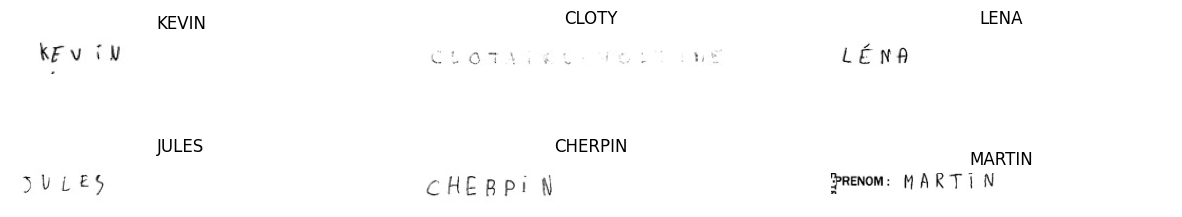

In [ ]:
# test = pd.read_csv('written_name_test_v2.csv')

# plt.figure(figsize=(15, 10))
# for i in range(6):
#     ax = plt.subplot(2, 3, i+1)
#     img_dir = 'test_v2/test/'+test.loc[i, 'FILENAME']
#     image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
#     plt.imshow(image, cmap='gray')

#     image = preprocess(image)
#     image = image/255.
#     pred = model.predict(image.reshape(1, 256, 64, 1))
#     decoded = K.get_value(K.ctc_decode(pred, input_length=np.ones(pred.shape[0])*pred.shape[1],
#                                        greedy=True)[0][0])
#     plt.title(num_to_label(decoded[0]), fontsize=12)
#     plt.axis('off')

# plt.subplots_adjust(wspace=0.2, hspace=-0.8)

# ___________________________________________________________________________________________________________________________________________________________
# ___________________________________________________________________________________________________________________________________________________________
# v2

# test = pd.read_csv('written_name_test_v2.csv')

# plt.figure(figsize=(15, 10))
# for i in range(6):
#     ax = plt.subplot(2, 3, i+1)
#     img_dir = 'test_v2/test/' + test.loc[i, 'FILENAME']
#     image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
#     plt.imshow(image, cmap='gray')

#     # Preprocess the image
#     image = preprocess(image)
#     image = image / 255.0

#     # Make predictions
#     pred = model.predict(image.reshape(1, 256, 64, 1))

#     # Decode predictions using ctc_decode
#     decoded, _ = ctc_decode(
#         pred,
#         input_length=np.ones(pred.shape[0]) * pred.shape[1],
#         greedy=True
#     )

#     # Convert sparse tensor to dense numpy array
#     decoded = np.array(decoded[0]).astype(int)

#     # Convert numeric predictions to labels
#     decoded_label = num_to_label(decoded[0])

#     # Display the result
#     plt.title(decoded_label, fontsize=12)
#     plt.axis('off')

# plt.subplots_adjust(wspace=0.2, hspace=-0.8)

# ___________________________________________________________________________________________________________________________________________________________
# ___________________________________________________________________________________________________________________________________________________________
# v3
# Import ctc_decode
from tensorflow.keras.backend import ctc_decode

test = pd.read_csv('written_name_test_v2.csv')

plt.figure(figsize=(15, 10))
for i in range(6):
    ax = plt.subplot(2, 3, i+1)
    img_dir = 'test_v2/test/' + test.loc[i, 'FILENAME']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    plt.imshow(image, cmap='gray')

    # Preprocess the image
    image = preprocess(image)
    image = image / 255.0

    # Make predictions
    pred = model.predict(image.reshape(1, 256, 64, 1))

    # Decode predictions using ctc_decode
    decoded, _ = ctc_decode(
        pred,
        input_length=np.ones(pred.shape[0]) * pred.shape[1],
        greedy=True
    )

    # Convert sparse tensor to dense numpy array
    decoded = np.array(decoded[0]).astype(int)

    # Convert numeric predictions to labels
    decoded_label = num_to_label(decoded[0])

    # Display the result
    plt.title(decoded_label, fontsize=12)
    plt.axis('off')

plt.subplots_adjust(wspace=0.2, hspace=-0.8)


code that take input and pred the image

In [ ]:
# Function to predict text from a single image
def predict_text(image_path, model, preprocess, num_to_label):
    # """
    # Predict the text written in a single image.

    # Parameters:
    # - image_path: str, path to the image file
    # - model: trained model
    # - preprocess: function to preprocess the image
    # - num_to_label: function to convert predictions to labels

    # Returns:
    # - predicted_text: str, the predicted text
    # """
    import cv2
    from tensorflow.keras.backend import ctc_decode
    import numpy as np

    # Load the image
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        raise ValueError(f"Image not found at path: {image_path}")

    # Preprocess the image
    image = preprocess(image)
    image = image / 255.0  # Normalize the pixel values

    # Add batch dimension and predict
    pred = model.predict(image.reshape(1, 256, 64, 1))

    # Decode predictions using ctc_decode
    decoded, _ = ctc_decode(
        pred,
        input_length=np.ones(pred.shape[0]) * pred.shape[1],
        greedy=True
    )

    # Convert sparse tensor to dense numpy array
    decoded = np.array(decoded[0]).astype(int)

    # Convert numeric predictions to labels
    predicted_text = num_to_label(decoded[0])

    return predicted_text




In [ ]:
# # Example usage
# # image_path = "/content/test_01.png"
# image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
# print(image)
# # image = "/content/test_01.png"
# try:
#     # plt.title(image, fontsize=12)
#     # plt.axis('off')
#     predicted_text = predict_text(image, model, preprocess, num_to_label)
#     print("Predicted Text:", predicted_text)
# except ValueError as e:
#     print(e)

[[ 58  88 117 ... 255 255 255]
 [ 56  86 115 ... 255 255 255]
 [ 52  83 113 ... 255 255 255]
 ...
 [ 43  50  60 ... 254 254 254]
 [ 50  58  69 ... 255 254 254]
 [ 51  59  70 ... 255 255 254]]


error: OpenCV(4.10.0) :-1: error: (-5:Bad argument) in function 'imread'
> Overload resolution failed:
>  - Expected 'filename' to be a str or path-like object
>  - Expected 'filename' to be a str or path-like object
>  - Expected 'filename' to be a str or path-like object


In [ ]:
# Example usage
image_path = "/content/test_02.png"

# Load the image using cv2
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

print(image)

if image is not None:
    try:
        # Preprocess the image
        # Resize to match the model input dimensions (256x64)
        image = cv2.resize(image, (256, 64))

        # Normalize the pixel values to the range [0, 1]
        image = image
        # Add batch dimension (batch_size, height, width, channels)
        image = image.reshape(1, 256, 64, 1)

        # Predict using the model
        pred = model.predict(image)

        # Decode predictions using ctc_decode
        decoded, _ = ctc_decode(
            pred,
            input_length=np.ones(pred.shape[0]) * pred.shape[1],
            greedy=True
        )

        # Convert sparse tensor to dense numpy array
        decoded = np.array(decoded[0]).astype(int)

        # Convert numeric predictions to text
        predicted_text = num_to_label(decoded[0])

        # Display the predicted text
        print("Predicted Text:", predicted_text)

    except ValueError as e:
        print("Error during prediction:", e)
else:
    print("Error: Could not read image from path:", image_path)


[[171 171 170 ... 183 183 183]
 [171 171 170 ... 183 183 183]
 [171 171 170 ... 183 183 183]
 ...
 [156 156 156 ... 180 180 179]
 [156 156 156 ... 180 179 179]
 [157 157 157 ... 180 179 179]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Predicted Text: LULY


In [ ]:
# Example usage
image_path = "/content/test_01.png"

# Load the image using cv2
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

print(image)

if image is not None:
    try:
        # Preprocess the image
        def preprocess(image):
            # Resize the image to 256x64
            image = cv2.resize(image, (256, 64))
            # Normalize pixel values to [0, 1]
            image = image / 255.0
            return image

        # Preprocess the image
        image = preprocess(image)

        # Add batch dimension (batch_size, height, width, channels)
        image = image.reshape(1, 256, 64, 1)

        # Predict using the model
        pred = model.predict(image)

        # Decode predictions using ctc_decode
        decoded, _ = ctc_decode(
            pred,
            input_length=np.ones(pred.shape[0]) * pred.shape[1],
            greedy=True
        )

        # Convert sparse tensor to dense numpy array
        decoded = np.array(decoded[0]).astype(int)

        # Convert numeric predictions to text
        def num_to_label(numeric_sequence):
            # Define your label mapping
            labels = "abcdefghijklmnopqrstuvwxyz"
            return "".join(labels[i] for i in numeric_sequence if i < len(labels))

        predicted_text = num_to_label(decoded[0])

        # Display the predicted text
        print("Predicted Text:", predicted_text)

    except ValueError as e:
        print("Error during prediction:", e)
else:
    print("Error: Could not read image from path:", image_path)


[[ 58  88 117 ... 255 255 255]
 [ 56  86 115 ... 255 255 255]
 [ 52  83 113 ... 255 255 255]
 ...
 [ 43  50  60 ... 254 254 254]
 [ 50  58  69 ... 255 254 254]
 [ 51  59  70 ... 255 255 254]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Predicted Text: letazzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzz


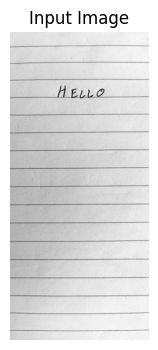

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


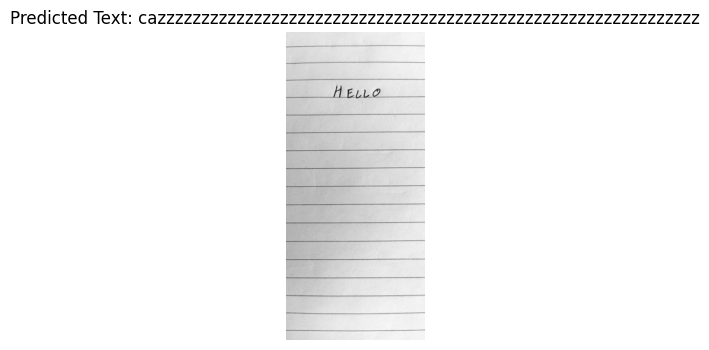

Predicted Text: cazzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzz


In [ ]:
image_path = "/content/test_02.png"

# Load the image using cv2
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# Display the original image
plt.figure(figsize=(6, 4))
plt.imshow(image, cmap='gray')
plt.title("Input Image")
plt.axis('off')
plt.show()

if image is not None:
    try:
        # Preprocess the image
        processed_image = preprocess(image)

        # Add batch dimension (batch_size, height, width, channels)
        processed_image = processed_image.reshape(1, 256, 64, 1)

        # Predict using the model
        pred = model.predict(processed_image)

        # Decode predictions using ctc_decode
        decoded, _ = ctc_decode(
            pred,
            input_length=np.ones(pred.shape[0]) * pred.shape[1],
            greedy=True
        )

        # Convert sparse tensor to dense numpy array
        decoded = np.array(decoded[0]).astype(int)

        # Convert numeric predictions to text
        predicted_text = num_to_label(decoded[0])

        # Display the processed image and predicted text
        plt.figure(figsize=(6, 4))
        plt.imshow(image, cmap='gray')
        plt.title(f"Predicted Text: {predicted_text}")
        plt.axis('off')
        plt.show()

        # Print the predicted text
        print("Predicted Text:", predicted_text)

    except ValueError as e:
        print("Error during prediction:", e)
else:
    print("Error: Could not read image from path:", image_path)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


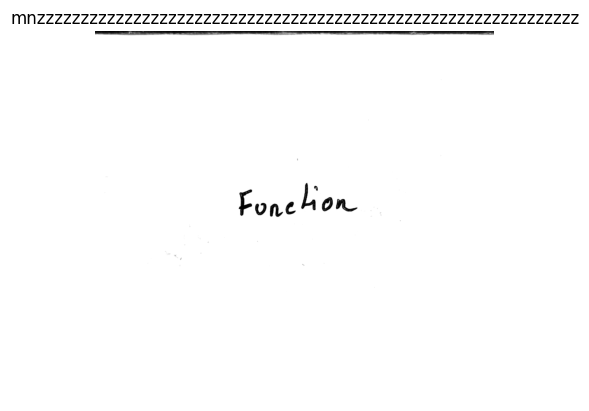

In [ ]:
img_dir = '/content/test_03.png'
image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
plt.imshow(image, cmap='gray')

# Preprocess the image
image = preprocess(image)
image = image / 255.0

# Make predictions
pred = model.predict(image.reshape(1, 256, 64, 1))

# Decode predictions using ctc_decode
decoded, _ = ctc_decode(
    pred,
    input_length=np.ones(pred.shape[0]) * pred.shape[1],
    greedy=True
)

# Convert sparse tensor to dense numpy array
decoded = np.array(decoded[0]).astype(int)

# Convert numeric predictions to labels
decoded_label = num_to_label(decoded[0])

# Display the result
plt.title(decoded_label, fontsize=12)
plt.axis('off')

plt.subplots_adjust(wspace=0.2, hspace=-0.8)
